In [12]:
# If jupyter kernel can't find these libraries, install them using the code in this cell
# (hopefully this would only be necessary once on a given machine)
#!{sys.executable} -m pip install networkx
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install statistics

In [13]:
# import statements and globals

import networkx as nx
import queue
import math
import functools as ft
import matplotlib.pyplot as plt
import statistics as stats
from datetime import datetime

# use this as the size of graphs in all experiments 
N = 128 

# use these variables to specify how we will treat the fi/local assort. of a 0-degree vertex
ZERO_DEG_FI = 1
ZERO_DEG_LA = 0

# use this variable to specify whether or not we should include 0-degree vertices in AFI
EXCLUDE_ZERO_DEG = False 


In [27]:
# will give numbers 0 .. n in "bisecting" order, for example: 0, 4, 2, 6, 1, 5, 3, 7
def bisect_series(n):
    if n < 2 or not ((n & (n - 1)) == 0): raise Exception('n must be a power of 2, (n is ' + str(n) + ')') #http://code.activestate.com/recipes/577514-chek-if-a-number-is-a-power-of-two/
    yield 0
    yield n//2
    if not n > 2: return
    q = queue.Queue()
    q.put((n//4, 0, n//2)) # A tuple contains the next number to add, and the two numbers that were outside of it when added
    while not q.empty():
        t = q.get()
        yield t[0]
        yield (t[0] + n//2)%n
        if t[0] - t[1] > 1:
            q.put((((t[0] + t[1])//2), t[1], t[0]))
            q.put((((t[0] + t[2])//2), t[0], t[2]))

# wrapper for graph assortativity to avoid message in d-regular graph
def assort(graph):
    first_degree = graph.degree(list([v for v in graph.nodes() if graph.degree(v) > 0])[0])
    if all(graph.degree(v) == first_degree or graph.degree(v) == 0 for v in list(graph.nodes())): return 1.0
    return nx.degree_assortativity_coefficient(graph)

def fi(graph, vertex):
    if len(vertex) == 0: return ZERO_DEG_FI # zero degree vertex, predefined value
    return ft.reduce(lambda x, y: x + y, [graph.degree(nbr) for nbr in vertex])/len(vertex)**2

def vrtx_lst(graph):
    return [graph[v] for v in graph.nodes() if len(graph[v]) > 0 or not EXCLUDE_ZERO_DEG]

def afi(graph):
    return sum(fi(graph, v) for v in vrtx_lst(graph))/len(vrtx_lst(graph))

def gfi(graph):
    return sum(math.log(fi(graph, v)) for v in vrtx_lst(graph))/len(vrtx_lst(graph))

def gfi_norm(graph):
    return gfi(graph)/math.log(len(vrtx_lst(graph)))

def hfi(graph):
    return len(vrtx_lst(graph))/sum(1/fi(graph, v) for v in vrtx_lst(graph))

def tla_vector(graph):
    r = assort(graph)
    l = (r + 1)/len(vrtx_lst(graph))
    d1_v = [None if len(v) == 0 else sum([abs(len(v) - graph.degree(nbr)) for nbr in v])/len(v)
            for v in vrtx_lst(graph)]
    s = sum(d1 for d1 in d1_v if not d1 is None)
    d2_v = [None if d1 is None else d1 / s for d1 in d1_v]
    d3_v = [ZERO_DEG_LA if d2 is None else l - d2 for d2 in d2_v]
    return d3_v

def pla_vector(graph):
    endpoints = list(sum([(graph.degree(e[0]) - 1, graph.degree(e[1]) - 1) for e in graph.edges()], ()))
    mu = stats.mean(endpoints)
    denom = 2 * len(graph.edges()) * stats.pvariance(endpoints)
    return [ZERO_DEG_LA if len(v) == 0 else ((len(v) - 1)*len(v)*(stats.mean([graph.degree(nbr) - 1 for nbr in v]) - mu))/denom 
            for v in vrtx_lst(graph)]


In [28]:
# Tests:
# FILL IN TESTS

g1 = nx.Graph()
g1.add_edges_from([(1, 2), (2, 3), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7)])
print(list(sum([(g1.degree(e[0]) - 1, g1.degree(e[1]) - 1) for e in g1.edges()], ())))

g2 = nx.Graph()
g2.add_edges_from([(1, 2), (2, 3), (1, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7)])

print('g1 PLA: ' + str(pla_vector(g1)))
print('g1 TLA: ' + str(tla_vector(g1)))


print('g2 PLA: ' + str(pla_vector(g2)))
print('g2 TLA: ' + str(tla_vector(g2)))

[0, 1, 1, 0, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1]
g1 PLA: [-0.0, -0.375, -0.0, 0.2083333333333333, 0.04166666666666652, 0.04166666666666652, 0.2083333333333333]
g1 TLA: [0.0028195488721805273, 0.0028195488721805273, 0.0028195488721805273, 0.0028195488721805273, 0.055451127819548959, 0.055451127819548959, 0.0028195488721805273]
g2 PLA: [-0.04999999999999998, -0.13999999999999999, 0.04000000000000002, 0.12000000000000005, -0.2999999999999999, 0.12000000000000005, 0.13000000000000003]
g2 TLA: [0.045714285714285707, 0.13142857142857142, -0.040000000000000008, 0.01714285714285714, -0.12571428571428575, 0.01714285714285714, -0.12571428571428575]


In [29]:
         
"""            
g1 = nx.Graph()
g1.add_edges_from([(1, 2), (2, 3), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7)])
g2 = nx.Graph()
g2.add_edges_from([(1, 2), (2, 3), (1, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7)])

print('g1 PLA: ' + str(pla_vector(g1)))
print('g1 TLA: ' + str(sorted(tla_vector(g1))))

print('g2 PLA: ' + str(sorted(pla_vector(g2))))
print('g2 TLA: ' + str(sorted(tla_vector(g2))))


g = nx.Graph()
with open(r'powergrid') as f:
    for l in f:
        if not l[0] == '%': g.add_edge(int(l.split()[0]), int(l.split()[1]))


print ('assort: ' + str(assort(g)))
print ('afi: ' + str(afi(g)))
print ('gfi: ' + str(gfi(g)))
print ('gfi_norm: ' + str(gfi_norm(g)))
print ('hfi: ' + str(hfi(g)))

g = nx.erdos_renyi_graph(20, 0.05, 0)
print(g.edges())
print(afi(g))
print([fi(g, g[v]) for v in g])
print(tla_vector(g))
print(pla_vector(g))
"""

"            \ng1 = nx.Graph()\ng1.add_edges_from([(1, 2), (2, 3), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7)])\ng2 = nx.Graph()\ng2.add_edges_from([(1, 2), (2, 3), (1, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7)])\n\nprint('g1 PLA: ' + str(pla_vector(g1)))\nprint('g1 TLA: ' + str(sorted(tla_vector(g1))))\n\nprint('g2 PLA: ' + str(sorted(pla_vector(g2))))\nprint('g2 TLA: ' + str(sorted(tla_vector(g2))))\n\n\ng = nx.Graph()\nwith open(r'powergrid') as f:\n    for l in f:\n        if not l[0] == '%': g.add_edge(int(l.split()[0]), int(l.split()[1]))\n\n\nprint ('assort: ' + str(assort(g)))\nprint ('afi: ' + str(afi(g)))\nprint ('gfi: ' + str(gfi(g)))\nprint ('gfi_norm: ' + str(gfi_norm(g)))\nprint ('hfi: ' + str(hfi(g)))\n\ng = nx.erdos_renyi_graph(20, 0.05, 0)\nprint(g.edges())\nprint(afi(g))\nprint([fi(g, g[v]) for v in g])\nprint(tla_vector(g))\nprint(pla_vector(g))\n"

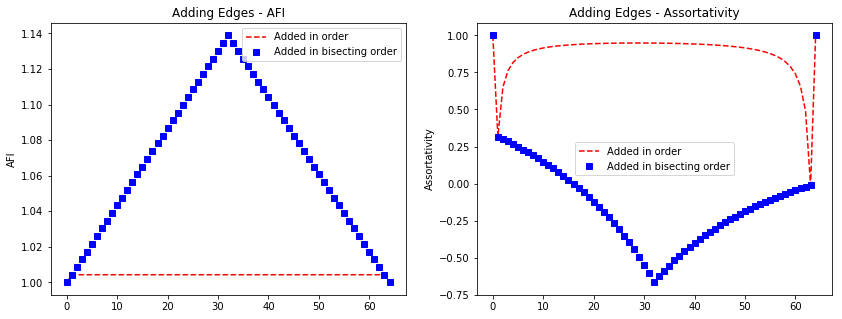

In [30]:
# This experiment will start with a cycle, then add "diameters", so it progresses from a 2-regular graph to a 3-regular graph
g1 = nx.Graph()
g2 = nx.Graph()

for i in range(N):
    g1.add_node(i)
    g2.add_node(i)
    
for i in range(N):
    g1.add_edge(i, (i+1)%N)
    g2.add_edge(i, (i+1)%N)
    
afis1 = [afi(g1)]
assorts1 = [assort(g1)]
afis2 = [afi(g2)]
assorts2 = [assort(g2)]

for i in range(N//2):
    g1.add_edge(i, i + N//2)
    afis1.append(afi(g1))
    assorts1.append(assort(g1))
    
for i in bisect_series(N//2):
    if not i + N//2 in g2[i]:
        g2.add_edge(i, i + N//2)
        afis2.append(afi(g2))
        assorts2.append(assort(g2))

plt.figure(figsize=(14, 5))
        
plt.subplot(1, 2, 1)
plt.title('Adding Edges - AFI')
plt.plot(afis1, 'r--', label='Added in order')
plt.plot(afis2, 'bs', label='Added in bisecting order')
plt.ylabel('AFI')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Adding Edges - Assortativity')
plt.plot(assorts1, 'r--', label='Added in order')
plt.plot(assorts2, 'bs', label='Added in bisecting order')
plt.ylabel('Assortativity')
plt.legend()

plt.show()


In [34]:
# Experiment with mulitthreading
import multiprocessing


    
starttime = datetime.now()
jobs = []

def f():
    g = nx.erdos_renyi_graph(1000, 0.1)
    afis.append(afi(g))

for i in range(0, 50):
    process = multiprocessing.Process(target = f)
    jobs.append(process)
    
for j in jobs:
    j.start()

for j in jobs:
    j.join()
    
print(afis)
print (datetime.now() - starttime)   



starttime = datetime.now()

afis = []
for i in range(0, 50):
    g = nx.erdos_renyi_graph(1000, 0.1)
    afis.append(afi(g))

print(afis)
print (datetime.now() - starttime)

[1.0191880724478735, 1.0195914003500275, 1.0186212574468845, 1.018790854075641, 1.01926754724251, 1.0183656778656769, 1.0192293127504508, 1.0185628097413153, 1.0200453740810167, 1.0183263463417327, 1.0184989155445532, 1.0175128927644888, 1.017719515885674, 1.0172856030035828, 1.0180926734864075, 1.0188262784108124, 1.019023727705975, 1.017949040507353, 1.0185258912465327, 1.0175936066271338]
0:00:00.482028
[1.0174324771736625, 1.0179037430069628, 1.019294279354764, 1.0191672480752043, 1.0182562124916565, 1.0192766943548892, 1.0181738995070662, 1.0176247897635042, 1.0183304551719892, 1.017362619353253, 1.0184852755402838, 1.016094284033979, 1.018473446399507, 1.0181903626006976, 1.019113385131052, 1.0190485483169935, 1.0181592747975794, 1.0177983654089782, 1.019388425498489, 1.0176627400280993, 1.0196280438568217, 1.0183462683365978, 1.01958708812102, 1.0192146769164727, 1.0180572007287576, 1.01697506292483, 1.0189562491052893, 1.017381106220276, 1.0176922665060533, 1.0176089846072047, 